In [1]:
import numpy as np 
import pandas as pd
import neattext.functions as nfx
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import BatchNormalization, LSTM, Dropout, GlobalMaxPooling1D, Embedding, Input, Dense
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
import pickle

tf.config.list_physical_devices('GPU')

In [4]:
data=pd.read_csv('../dataset/Suicide_Detection.csv')

In [5]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=np.random.randint(10))

In [6]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for str in tqdm(text):
        str=str.lower()
        str=nfx.remove_emails(str)
        str=nfx.remove_urls(str)
        str=nfx.remove_special_characters(str)
        str=nfx.remove_stopwords(str)
        text_length.append(len(str.split()))
        cleaned_text.append(str)
    return cleaned_text,text_length

In [7]:
cleaned_train_text, train_text_length = clean_text(train_data.text)
cleaned_test_text, test_text_length = clean_text(test_data.text)

100%|██████████| 46415/46415 [00:06<00:00, 7068.67it/s] 


In [8]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

word_frequency = pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)
print(word_frequency)

                 word   count
0                  im  261413
72               dont  170270
86               like  144153
66               want  118993
17               know  104034
...               ...     ...
129601         yeslmk       1
129602           sex3       1
129603  classesliving       1
129604   girlsimagine       1
264062     survivebut       1

[264063 rows x 2 columns]


In [9]:
tokenizer.word_index

{'im': 1,
 'dont': 2,
 'like': 3,
 'want': 4,
 'know': 5,
 'feel': 6,
 'life': 7,
 'ive': 8,
 'cant': 9,
 'people': 10,
 'time': 11,
 'think': 12,
 'going': 13,
 'friends': 14,
 'filler': 15,
 'day': 16,
 'help': 17,
 'years': 18,
 'things': 19,
 'got': 20,
 'good': 21,
 'fucking': 22,
 'school': 23,
 'way': 24,
 'anymore': 25,
 'need': 26,
 'didnt': 27,
 'family': 28,
 'better': 29,
 'die': 30,
 'end': 31,
 'love': 32,
 'talk': 33,
 'kill': 34,
 'live': 35,
 'fuck': 36,
 'year': 37,
 'ill': 38,
 'suicide': 39,
 'right': 40,
 'hate': 41,
 'work': 42,
 'shit': 43,
 'thing': 44,
 'bad': 45,
 'person': 46,
 'parents': 47,
 'told': 48,
 'friend': 49,
 'care': 50,
 'thats': 51,
 'mom': 52,
 'thought': 53,
 'tell': 54,
 'said': 55,
 'doesnt': 56,
 'point': 57,
 'getting': 58,
 'tried': 59,
 'try': 60,
 'happy': 61,
 'job': 62,
 'long': 63,
 'feeling': 64,
 'away': 65,
 'find': 66,
 'trying': 67,
 'lot': 68,
 'wanted': 69,
 'pain': 70,
 'started': 71,
 'tired': 72,
 'best': 73,
 'depression':

# Process Text For the Model

In [10]:
train_text_seq= tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad= pad_sequences(train_text_seq,maxlen=100)

test_text_seq= tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad= pad_sequences(test_text_seq,maxlen=100)

In [11]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

# Embedding Model 

In [12]:
with open('../dataset/glove.840B.300d.pkl', 'rb') as fp:
    glove = pickle.load(fp)

In [13]:
dataset_length=len(tokenizer.word_index) + 1

embedding_matrix=np.zeros((dataset_length,300), dtype=float) #pad 0 to prep the matrix to match with the shape of our dataset
for word,i in tokenizer.word_index.items():
    num = glove.get(word)
    if num is not None:
        embedding_matrix[i] = num

# Model Building

In [14]:
model=tf.keras.models.Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(dataset_length,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          79219200  
                                                                 
 lstm (LSTM)                 (None, 100, 20)           25680     
                                                                 
 global_max_pooling1d (Globa  (None, 20)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [15]:
early_break = EarlyStopping(monitor='loss', patience=5)
reduce_learning_rate = ReduceLROnPlateau(patience=3)

result=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=30,batch_size=10,callbacks=[early_break,reduce_learning_rate])

Epoch 1/30
18566/18566 [==============================] - 351s 19ms/step - loss: 0.2317 - accuracy: 0.9136 - val_loss: 0.1998 - val_accuracy: 0.9247 - lr: 0.1000
Epoch 2/30
18566/18566 [==============================] - 338s 18ms/step - loss: 0.1825 - accuracy: 0.9362 - val_loss: 0.1697 - val_accuracy: 0.9362 - lr: 0.1000
Epoch 3/30
18566/18566 [==============================] - 395s 21ms/step - loss: 0.1725 - accuracy: 0.9406 - val_loss: 0.1668 - val_accuracy: 0.9366 - lr: 0.1000
Epoch 4/30
18566/18566 [==============================] - 352s 19ms/step - loss: 0.1624 - accuracy: 0.9446 - val_loss: 0.1846 - val_accuracy: 0.9336 - lr: 0.1000
Epoch 5/30
18566/18566 [==============================] - 316s 17ms/step - loss: 0.1559 - accuracy: 0.9470 - val_loss: 0.1802 - val_accuracy: 0.9375 - lr: 0.1000
Epoch 6/30
18566/18566 [==============================] - 355s 19ms/step - loss: 0.1521 - accuracy: 0.9489 - val_loss: 0.1567 - val_accuracy: 0.9401 - lr: 0.1000
Epoch 7/30
18566/18566 [====

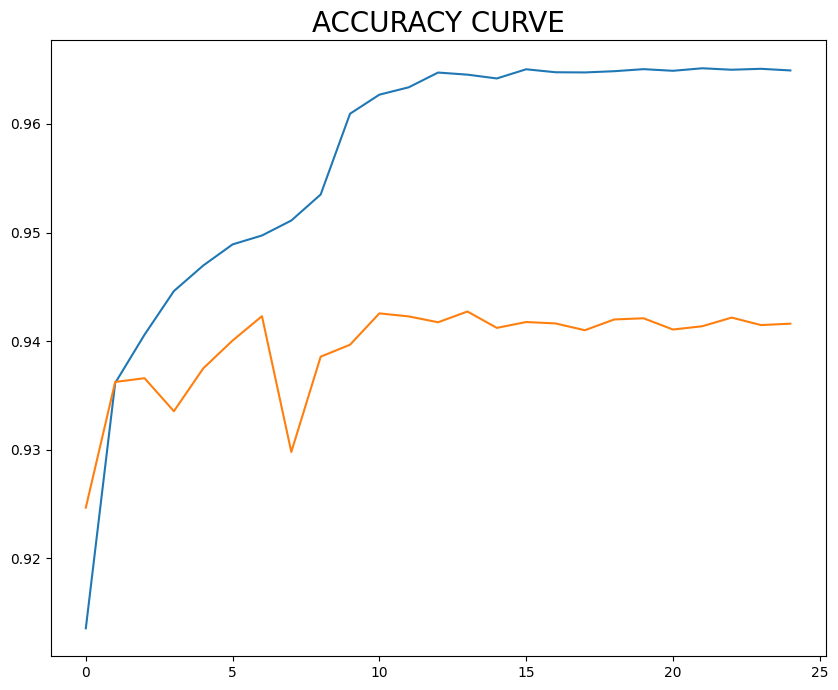

In [16]:
plt.figure(figsize=(10,8))
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

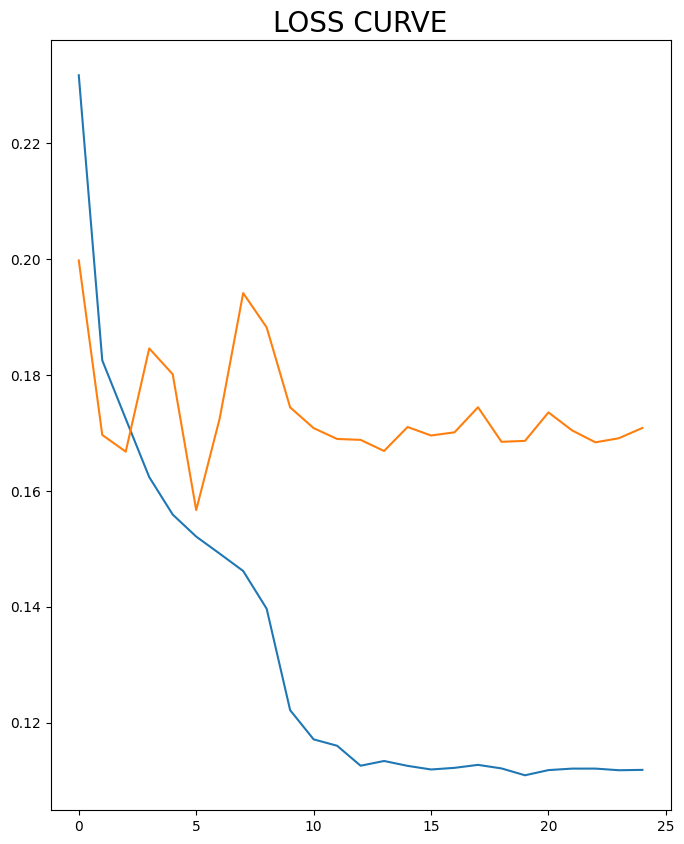

In [17]:
plt.figure(figsize=(8,10))
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [89]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets
